In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import random
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import AutoImageProcessor
from torch.utils.data import Dataset
from PIL import Image

In [2]:
model = torchvision.models.vit_b_16(pretrained=True)  


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 71.9MB/s]


In [3]:
model.conv_proj = torch.nn.Conv2d(1, 768, kernel_size=(16,16), stride=(16,16))

In [4]:
# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
"""torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False"""

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(15),          
    transforms.ToTensor()                   
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor()                  
])

# Load the full CIFAR-10 dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_val_transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Apply the validation transform to the validation dataset
val_dataset.dataset.transform = test_val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the sizes
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 55672187.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1534295.44it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13411519.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2095306.73it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train size: 48000
Validation size: 12000
Test size: 10000


In [5]:
model.heads.head.out_features = 10

In [6]:
model

VisionTransformer(
  (conv_proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [7]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 224, 224])

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [9]:
from tqdm import tqdm

In [10]:
num_epochs = 100
patience = 2  # Patience for early stopping
best_val_loss = np.inf
patience_counter = 0

In [11]:
# Lists to store learning curve data
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [12]:
model= model.to("cuda")

In [13]:
# Define the training step function
def train_step(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()

        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [14]:
# Define the validation step function
def val_step(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to("cuda")
            labels = labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    return avg_val_loss, val_accuracy

In [15]:
for epoch in range(num_epochs):
    # Training step
    avg_train_loss, train_accuracy = train_step(model, train_loader, optimizer, criterion)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # Validation step
    avg_val_loss, val_accuracy = val_step(model, val_loader, criterion)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model checkpoint
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break




Training: 100%|██████████| 750/750 [15:05<00:00,  1.21s/it]


Epoch 1/100, Training Loss: 0.3131388434432447, Training Accuracy: 89.79%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.55it/s]


Validation Loss: 0.03817983250198093, Validation Accuracy: 98.88%
Model saved.


Training: 100%|██████████| 750/750 [15:05<00:00,  1.21s/it]


Epoch 2/100, Training Loss: 0.030359787254594265, Training Accuracy: 99.08%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.55it/s]


Validation Loss: 0.026457079888403196, Validation Accuracy: 99.12%
Model saved.


Training: 100%|██████████| 750/750 [15:05<00:00,  1.21s/it]


Epoch 3/100, Training Loss: 0.02200929832609836, Training Accuracy: 99.28%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.55it/s]


Validation Loss: 0.022336453899426605, Validation Accuracy: 99.35%
Model saved.


Training: 100%|██████████| 750/750 [15:05<00:00,  1.21s/it]


Epoch 4/100, Training Loss: 0.018182666826624578, Training Accuracy: 99.41%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.55it/s]


Validation Loss: 0.029758558135499505, Validation Accuracy: 99.15%


Training: 100%|██████████| 750/750 [15:04<00:00,  1.21s/it]


Epoch 5/100, Training Loss: 0.014500914494972676, Training Accuracy: 99.57%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.56it/s]


Validation Loss: 0.0184258641479283, Validation Accuracy: 99.48%
Model saved.


Training: 100%|██████████| 750/750 [15:04<00:00,  1.21s/it]


Epoch 6/100, Training Loss: 0.01400890103172666, Training Accuracy: 99.59%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.56it/s]


Validation Loss: 0.02836756655272032, Validation Accuracy: 99.22%


Training: 100%|██████████| 750/750 [15:04<00:00,  1.21s/it]


Epoch 7/100, Training Loss: 0.01113712332030021, Training Accuracy: 99.66%


Validation: 100%|██████████| 188/188 [01:13<00:00,  2.56it/s]
/tmp/ipykernel_24/2418601638.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Validation Loss: 0.022343718723200158, Validation Accuracy: 99.40%
Early stopping triggered.


<All keys matched successfully>

In [ ]:

# Load the best model for evaluation
model.load_state_dict(torch.load("pixel-vit-mnist.pth"))

Evaluating Test Set: 100%|██████████| 157/157 [01:00<00:00,  2.57it/s]


Test Accuracy: 99.53%
Test F1 Score: 0.9953


ValueError: x and y must have same first dimension, but have shapes (100,) and (7,)

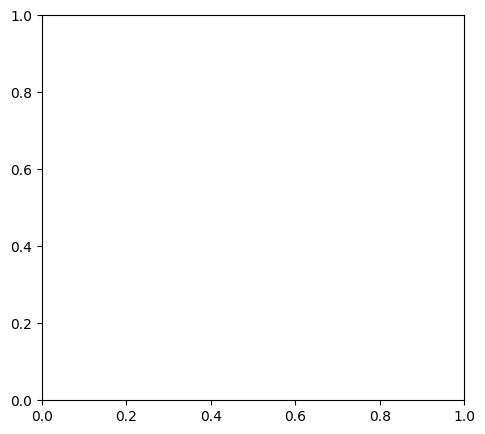

In [16]:
# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            images = images.to("cuda")
            labels=labels.to("cuda")
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Calculate F1 Score and Accuracy
    f1 = f1_score(test_labels, test_preds, average='weighted')
    accuracy = accuracy_score(test_labels, test_preds)
    return accuracy, f1

# Evaluate on the test set
test_accuracy, test_f1 = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
